In [1]:
"""
Notebook normalization – SWT Python 3.11 package

Goal:
Develop an adaptive indexing approach that leverages the matrix profile
on unevenly sampled, multivariate time series, using variable window lengths
tailored to local sampling density and signal behavior.
"""

# ---- Package imports ----

# Numerical computation
import numpy as np
#Manipulate row data format
import h5py as hp
# Data manipulation
import pandas as pd

# DTW and Soft-DTW distance functions for time series
from tslearn.metrics import dtw, soft_dtw

# Matrix Profile for pattern discovery and anomaly detection
import stumpy

# FAISS for fast vector indexing and similarity search
import faiss

# Plotting
import matplotlib.pyplot as plt

#Some normalisation functions
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

,timestamp,value
0,2015-09-01 13:45:00,3.06
1,2015-09-01 13:50:00,6.44
2,2015-09-01 13:55:00,5.17
3,2015-09-01 14:00:00,3.83
4,2015-09-01 14:05:00,4.50


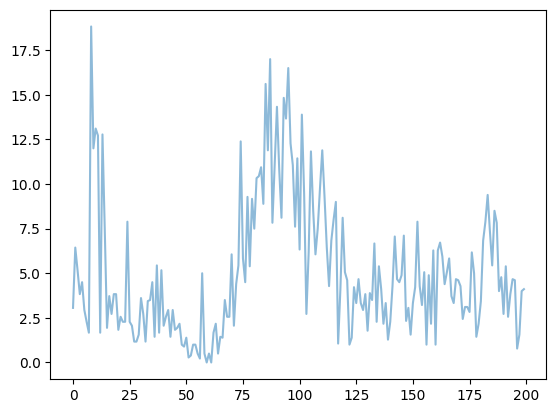

In [2]:
""" import of Dataset """
# occupancy of the Twin Cities Metro area in Minnesota
df = pd.read_csv('../../dataset/occupancy_6005.csv')
df = df.iloc[0:200]

#show graphic data
plt.plot(df['value'], label='Original', alpha=0.5)

#show csv data 
df.head()

In [3]:
""" Handle missing values """
window_size = 40

#Standart normalization 
df['zscore'] = StandardScaler().fit_transform(df[['value']])

#Min Max normalization
df['minmax'] = MinMaxScaler().fit_transform(df[['value']])

#Robust Normalization
df['robust'] = RobustScaler().fit_transform(df[['value']])

#Window standart normalization
df['sw_zscore'] = df['value'].rolling(window=window_size, min_periods=1).apply(lambda x: (x.iloc[-1] - x.mean()) / x.std() if x.std() != 0 else 0)

#ASWN normalization 
def adaptive_sliding_window_normalization(series, window_size=10):
    """
    Adaptive Sliding Window Normalization (ASWN) with edge-safe handling and interpolation.

    Parameters:
        series (pd.Series): The input time series to normalize.
        window_size (int): Size of the sliding window.

    Returns:
        pd.Series: The normalized time series.
    """
    normalized = pd.Series(index=series.index, dtype=float)
    for i in range(len(series)):
        start = max(0, i - window_size + 1)
        window = series.iloc[start:i+1]
        mean = window.mean()
        std = window.std()
        if std and not np.isnan(std):
            normalized.iloc[i] = (series.iloc[i] - mean) / std
        else:
            normalized.iloc[i] = np.nan  # mark for interpolation

    # Interpolate to fill initial NaN (e.g., at index 0)
    return normalized.interpolate(method="linear", limit_direction="both")
df['aswn'] = adaptive_sliding_window_normalization(df['value'], window_size)

#Rolling Mean normalization
df['rolling_mean'] = df['value'].rolling(window=window_size, min_periods=1).mean()


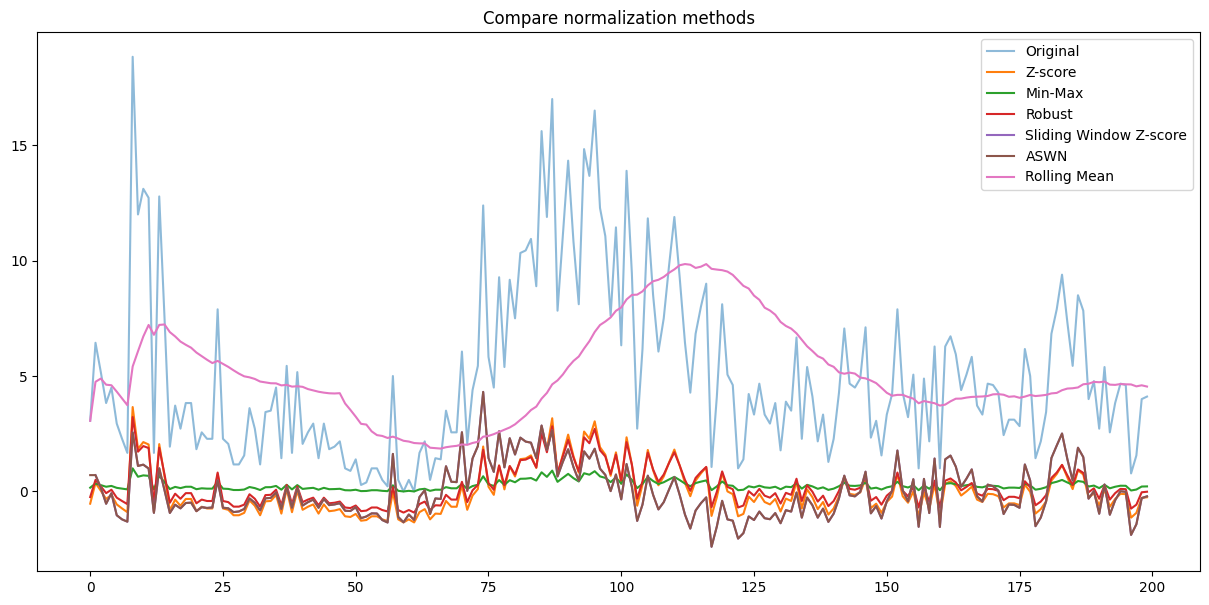

In [4]:
plt.figure(figsize=(15, 7))
plt.plot(df['value'], label='Original', alpha=0.5)
plt.plot(df['zscore'], label='Z-score')
plt.plot(df['minmax'], label='Min-Max')
plt.plot(df['robust'], label='Robust')
plt.plot(df['sw_zscore'], label='Sliding Window Z-score')
plt.plot(df['aswn'], label='ASWN')
plt.plot(df['rolling_mean'], label='Rolling Mean')
plt.legend()
plt.title('Compare normalization methods')
plt.show()


### Why ASWN is the Most Effective Normalization Method

Among the normalization methods tested, **Adaptive Sliding Window Normalization (ASWN)** demonstrates the best balance between local adaptability and robustness to anomalies.

- **Local Sensitivity**: Unlike standard Z-score or Min-Max normalization, ASWN uses a dynamic window to adapt the normalization to local patterns, preserving the shape of time-varying behaviors.
- **Anomaly Robustness**: Because it only considers a limited temporal context, ASWN is less affected by extreme values outside the window—making it more robust to outliers compared to global methods.
- **Pattern Preservation**: Unlike Rolling Mean (which smooths out informative variations), ASWN retains important fluctuation patterns needed for downstream tasks such as DTW similarity or Matrix Profile analysis.
- **Scientific Validity**: ASWN is designed specifically for non-stationary time series and is supported by recent literature as an effective preprocessing step before motif discovery, segmentation, and anomaly detection.

Overall, ASWN offers a more **context-aware and anomaly-resilient** normalization that is highly suited for complex, real-world time series data.


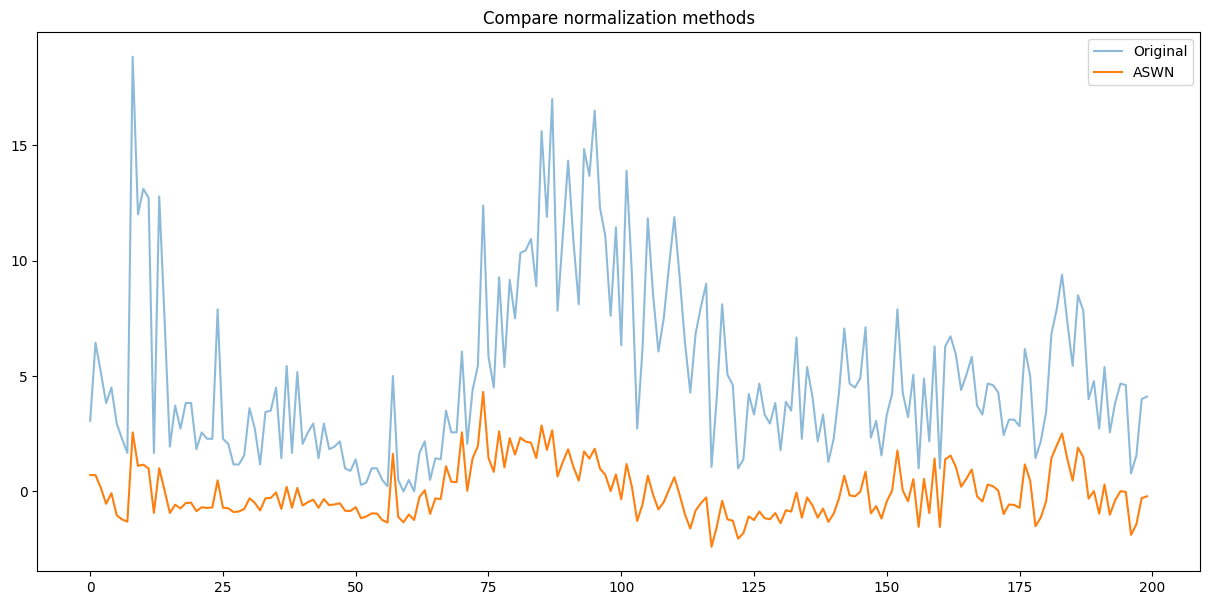

---ORIGINAL---
min value : 0.0
max value : 18.83
---ASWN SIGNAL---
min value : -2.3970256137044452
max value : 4.312146534319113


,value,aswn
0,3.06,0.707107
1,6.44,0.707107
2,5.17,0.164001
3,3.83,-0.533069
4,4.50,-0.077353


In [6]:
plt.figure(figsize=(15, 7))
plt.plot(df['value'], label='Original', alpha=0.5)
plt.plot(df['aswn'], label='ASWN')
plt.legend()
plt.title('Compare normalization methods')
plt.show()
print(f"---ORIGINAL---\nmin value : {df['value'].min()}\nmax value : {df['value'].max()}")
print(f"---ASWN SIGNAL---\nmin value : {df['aswn'].min()}\nmax value : {df['aswn'].max()}")
df[['value', 'aswn']].head()
